In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp

In [4]:
planck30 = hp.read_map('../data_files/LFI_SkyMap_030_1024_R2.01_full.fits')
planck44 = hp.read_map('../data_files/LFI_SkyMap_044_1024_R2.01_full.fits')
planck70 = hp.read_map('../data_files/LFI_SkyMap_070_1024_R2.01_full.fits')
planck100 = hp.read_map('../data_files/HFI_SkyMap_100_2048_R2.02_full.fits')
planck143 = hp.read_map('../data_files/HFI_SkyMap_143_2048_R2.02_full.fits')
planck217 = hp.read_map('../data_files/HFI_SkyMap_217_2048_R2.02_full.fits')
planck353 = hp.read_map('../data_files/HFI_SkyMap_353_2048_R2.02_full.fits')

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/samuel/anaconda3/envs/datasci/lib/python3.8/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [12]:
planck30 = hp.ud_grade(planck30, 512)
planck44 = hp.ud_grade(planck44, 512)
planck70 = hp.ud_grade(planck70, 512)
planck100 = hp.ud_grade(planck100, 512)
planck143 = hp.ud_grade(planck143, 512)
planck217 = hp.ud_grade(planck217, 512)
planck353 = hp.ud_grade(planck353, 512)

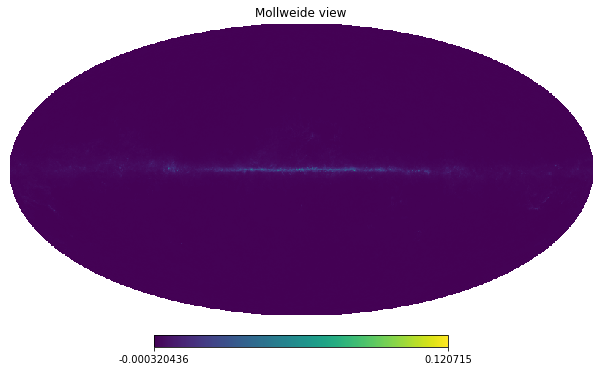

In [15]:
# plot of raw data

hp.mollview(planck217, nest=False)